# Regression Training

In [76]:
save_models_path = "/home/adrian_alvarez/Projects/NBA_over_under_predictor/models/dif_to_line/"
prefix_name = "regressor_dif_"

## Libraries

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [78]:
from nba_ou.data_preparation.missing_data.handle_missing_data import apply_missing_policy, compute_and_save_train_medians

## Load Data

In [79]:
data_path = "/home/adrian_alvarez/Projects/NBA_over_under_predictor/data/train_data/"
name = "training_data_from_2004-10-01_to_2026-01-10.csv"
path = data_path + name

df_stats = pd.read_csv(path)

dtype_dict = {col: str for col in df_stats.columns if "ID" in col.upper()}

df_stats = pd.read_csv(
    path,
    dtype=dtype_dict
)
df_stats['GAME_DATE'] = pd.to_datetime(df_stats['GAME_DATE']).dt.strftime('%Y-%m-%d')

/tmp/ipykernel_1321423/3758133838.py:5: DtypeWarning: Columns (205,206,207,248,249,250,291,292,293,334,335,336,377,378,379,420,421,422,616,617,618,659,660,661,702,703,704,745,746,747,788,789,790,831,832,833) have mixed types. Specify dtype option on import or set low_memory=False.
  df_stats = pd.read_csv(path)
/tmp/ipykernel_1321423/3758133838.py:9: DtypeWarning: Columns (205,206,207,248,249,250,291,292,293,334,335,336,377,378,379,420,421,422,616,617,618,659,660,661,702,703,704,745,746,747,788,789,790,831,832,833) have mixed types. Specify dtype option on import or set low_memory=False.
  df_stats = pd.read_csv(


In [80]:
df_stats= df_stats[df_stats['TOTAL_POINTS'] > 130]

In [81]:
df_stats.shape[0]

23691

In [82]:
df_stats

,TOTAL_OVER_UNDER_LINE,TEAM_ID_TEAM_HOME,TEAM_CITY_TEAM_HOME,TEAM_ABBREVIATION_TEAM_HOME,TEAM_NAME_TEAM_HOME,MATCHUP_TEAM_HOME,GAME_NUMBER_TEAM_HOME,TEAM_ID_TEAM_AWAY,TEAM_CITY_TEAM_AWAY,TEAM_ABBREVIATION_TEAM_AWAY,...,PTS_TREND_SLOPE_DIFF_HOME_MINUS_AWAY,PTS_TREND_SLOPE_SUM_HOME_PLUS_AWAY,TRAVEL_RECENCY_RATIO_HOME_2D_OVER_14D,TRAVEL_RECENCY_RATIO_AWAY_2D_OVER_14D,REST_DAYS_DIFF_HOME_MINUS_AWAY,INJURY_PTS_SHARE_HOME,INJURY_PTS_SHARE_AWAY,STAR_PTS_PCT_DIFF_HOME_MINUS_AWAY,POSS_X_TSPCT_HOME,POSS_X_TSPCT_AWAY
0,240.9999,1610612762,Utah,UTA,Utah Jazz,UTA vs. CHA,38,1610612766,Charlotte,CHA,...,1.7,-3.1,0.788795,0.000000,0,0.240990,0.133469,0.022339,60.680317,57.657276
1,240.4999,1610612739,Cleveland,CLE,Cleveland Cavaliers,CLE vs. MIN,40,1610612750,Minnesota,MIN,...,-10.7,-6.5,0.773813,0.000000,0,0.098350,0.080271,0.014506,59.123238,61.144985
2,214.4999,1610612765,Detroit,DET,Detroit Pistons,DET vs. LAC,38,1610612746,LA,LAC,...,-8.5,-3.3,0.000000,0.234741,2,0.495857,0.234389,-0.156275,58.487861,56.322250
3,236.4999,1610612754,Indiana,IND,Indiana Pacers,IND vs. MIA,39,1610612748,Miami,MIA,...,8.6,-1.6,0.727915,0.000000,-2,0.379738,0.021147,0.006671,56.971687,59.561623
4,233.4999,1610612741,Chicago,CHI,Chicago Bulls,CHI vs. DAL,38,1610612742,Dallas,DAL,...,2.3,0.1,0.000000,0.766714,1,0.289831,0.425103,-0.010188,58.130139,57.252427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23686,215.5000,1610612740,New Orleans,NOH,New Orleans Pelicans,NOH vs. SAC,1,1610612758,Sacramento,SAC,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
23687,191.0000,1610612739,Cleveland,CLE,Cleveland Cavaliers,CLE vs. DAL,1,1610612742,Dallas,DAL,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
23688,183.5000,1610612747,Los Angeles,LAL,Los Angeles Lakers,LAL vs. HOU,1,1610612745,Houston,HOU,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
23689,208.5000,1610612759,San Antonio,SAS,San Antonio Spurs,SAS vs. POR,1,1610612757,Portland,POR,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN


In [83]:
#count nas in TOTA_OVER_UNDER_LINE
nans = df_stats['TOTAL_OVER_UNDER_LINE'].isna().sum()
print(f"Number of NaNs in TOTAL_OVER_UNDER_LINE: {nans}")

Number of NaNs in TOTAL_OVER_UNDER_LINE: 1702


In [84]:
df_stats.dropna(subset=['TOTAL_OVER_UNDER_LINE'], inplace=True)
df_stats = df_stats[df_stats['TOTAL_OVER_UNDER_LINE'] > 100]

In [85]:
df_stats['SEASON_YEAR'].unique()

array([2025, 2024, 2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015,
       2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007])

In [86]:
#drop season 2007
df_stats = df_stats[df_stats['SEASON_YEAR'] != 2007]

In [87]:
df_to_train = df_stats.copy()

In [88]:
text_columns = df_to_train.select_dtypes(include=['object', 'string']).columns

# Print the names of the columns containing text
# print("Text columns:", list(text_columns))
cols_to_drop = ['SEASON_ID', 'GAME_ID', 'SEASON_TYPE',  'TEAM_ID_TEAM_HOME',
       'TEAM_ID_TEAM_AWAY','IS_OVERTIME']

cols_to_drop += [
    "MATCHUP_TEAM_HOME",
    "GAME_NUMBER_TEAM_HOME",
    "TEAM_CITY_TEAM_AWAY",
    "TEAM_ABBREVIATION_TEAM_AWAY",
    "TEAM_ABBREVIATION_TEAM_HOME",
    "TEAM_CITY_TEAM_HOME",
    "TEAM_NAME_TEAM_AWAY",
    "MATCHUP_TEAM_AWAY",
    'TEAM_NAME_TEAM_HOME'
]
cols_to_drop += list(text_columns)

cols_to_drop.pop(cols_to_drop.index('GAME_DATE'))

df_to_train.drop(columns=cols_to_drop, inplace=True, errors='ignore')


In [89]:
#Calculate number fo rows with at least 1 NA in total and in percentage
rows_with_na = df_to_train.isna().any(axis=1).sum()
total_rows = df_to_train.shape[0]
percentage_with_na = (rows_with_na / total_rows) * 100
print(f"Rows with at least one NA: {rows_with_na} out of {total_rows} ({percentage_with_na:.2f}%)")

Rows with at least one NA: 1862 out of 20775 (8.96%)


In [90]:
# Count NAs per column
na_counts = df_to_train.isna().sum()

# Get most common SEASON_YEAR for nulls in each column
most_common_season = []
for col in df_to_train.columns:
    if na_counts[col] > 0:
        # Get rows where this column is null
        null_rows = df_stats[df_stats[col].isna()]
        if len(null_rows) > 0 and 'SEASON_YEAR' in df_stats.columns:
            # Find most common SEASON_YEAR for these null rows
            common_season = null_rows['SEASON_YEAR'].mode()
            most_common_season.append(common_season.iloc[0] if len(common_season) > 0 else None)
        else:
            most_common_season.append(None)
    else:
        most_common_season.append(None)

na_counts_df = pd.DataFrame({
    'Column': na_counts.index,
    'NA_Count': na_counts.values,
    'NA_Percentage': (na_counts.values / len(df_to_train) * 100).round(2),
    'Most_Common_Season_Year': most_common_season
}).sort_values('NA_Count', ascending=False)

# Show only columns with NAs
na_counts_df[na_counts_df['NA_Count'] > 0]

,Column,NA_Count,NA_Percentage,Most_Common_Season_Year
514,TOTAL_OVER_UNDER_LINE_COMBINED_TREND_SLOPE_LAS...,627,3.02,2022.0
609,TRAVEL_RECENCY_RATIO_AWAY_2D_OVER_14D,561,2.70,2019.0
605,PTS_FORM_Z_AWAY_LAST5_VS_SEASON,561,2.70,2010.0
604,PTS_FORM_Z_HOME_LAST5_VS_SEASON,554,2.67,2022.0
494,AVG_POINTS_CONCEDED_AWAY_BEFORE_GAME,540,2.60,2008.0
...,...,...,...,...
528,REF_TRIO_DIFFERENCE_FROM_LINE_DIFF_BEFORE,23,0.11,2023.0
531,MONEYLINE_TEAM_HOME,12,0.06,2011.0
530,SPREAD,12,0.06,2011.0
597,IMPLIED_PTS_HOME,12,0.06,2011.0


In [91]:
# df_to_train.fillna(0, inplace=True)

In [92]:
print("Applying missing data policy...")
print(f"Data shape before handling missing data: {df_to_train.shape}")

Applying missing data policy...
Data shape before handling missing data: (20775, 616)


In [93]:
    # Training time
train_medians = compute_and_save_train_medians(df_to_train)

# Prediction time
df_to_train, report = apply_missing_policy(
    df_to_train,
    train_medians=train_medians,
    current_total_line_col="TOTAL_OVER_UNDER_LINE",
    drop_mode="strict",)

In [94]:
# report

In [95]:
print(f"Data shape after handling missing data: {df_to_train.shape}")

Data shape after handling missing data: (20379, 616)


In [96]:
null_rows = df_to_train[df_to_train.isnull().any(axis=1)]
print(f"Total number of null values in the DataFrame: {null_rows.shape[0]}")
print(f"Percentage of null values in the DataFrame: {null_rows.shape[0] / df_to_train.shape[0] * 100:.2f}%")
print(f"Total number of rows in the DataFrame: {df_to_train.shape[0]}")

null_columns = df_to_train.columns[df_to_train.isnull().any()].tolist()
print(f"Columns with null values: {null_columns}")


Total number of null values in the DataFrame: 0
Percentage of null values in the DataFrame: 0.00%
Total number of rows in the DataFrame: 20379
Columns with null values: []


In [97]:
df_to_train['LINE_ERROR'] = df_to_train['TOTAL_POINTS'] - df_to_train['TOTAL_OVER_UNDER_LINE']

In [98]:
df_to_train.drop(columns='GAME_DATE', inplace=True)

## Train / Test

In [99]:
from sklearn.model_selection import train_test_split

In [100]:
X = df_to_train.drop(cols_to_drop + ['LINE_ERROR', 'TOTAL_POINTS'], axis=1, errors='ignore')
y = df_to_train['LINE_ERROR']

In [101]:
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)

In [102]:
df_to_train['IS_TRAINING_DATA'] = False

# Mark True for the rows in the training set
df_to_train.loc[X_train.index, 'IS_TRAINING_DATA'] = True
output_name = f"{data_path}/training_data_with_missing_data_handled_from_2004-10-01_to_2026-01-10_dist.csv"
df_to_train.to_csv(output_name, index=False)

In [103]:
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
# Check number of coulmns
print(f"Number of columns in training set: {X_train.shape[1]}")
print(f"Number of columns in test set: {X_test.shape[1]}")

Training set size: 14265
Test set size: 6114
Number of columns in training set: 614
Number of columns in test set: 614


## Cross-validation

In [104]:
from sklearn.model_selection import KFold, cross_validate, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, root_mean_squared_error

In [105]:
# Declare KFold
kf = KFold(n_splits=5, shuffle=True, random_state=16)

In [106]:
# Custom scorer for over/under betting accuracy when predicting distance to line
def over_under_betting_accuracy(y_true, y_pred):
    """
    Calculate the accuracy of over/under betting decisions when predicting LINE_ERROR.
    
    Since we're predicting LINE_ERROR = TOTAL_POINTS - BETTING_LINE:
    - If LINE_ERROR > 0: game went OVER
    - If LINE_ERROR < 0: game went UNDER
    
    A bet is successful if:
    - We predict OVER (pred > 0) and actual is OVER (true > 0), OR
    - We predict UNDER (pred < 0) and actual is UNDER (true < 0)
    
    Parameters:
    -----------
    y_true : array-like
        Actual LINE_ERROR (actual total points - betting line)
    y_pred : array-like
        Predicted LINE_ERROR (predicted total points - betting line)
    
    Returns:
    --------
    float : Accuracy of betting decisions (0 to 1)
    """
    # Since we're predicting distance to line, we just need to check if signs match
    # np.sign returns -1, 0, or 1
    correct_predictions = np.sign(y_pred) == np.sign(y_true)
    
    # Calculate accuracy
    accuracy = np.mean(correct_predictions)
    
    return accuracy


# Custom scorer class to work with sklearn
class OverUnderScorer:
    """
    Custom scorer that calculates betting accuracy for over/under predictions.
    Works with LINE_ERROR predictions (distance to betting line).
    """
    def __call__(self, estimator, X, y_true):
        """
        Calculate the over/under betting accuracy.
        
        Parameters:
        -----------
        estimator : fitted estimator
            The model to evaluate
        X : DataFrame
            Features
        y_true : array-like
            Actual LINE_ERROR
        
        Returns:
        --------
        float : Betting accuracy score
        """
        y_pred = estimator.predict(X)
        return over_under_betting_accuracy(y_true, y_pred)


# Create a scorer object
over_under_scorer = OverUnderScorer()

In [108]:
# Declare scores to be used
scoring = {
    'MSE': make_scorer(mean_squared_error),
    'RMSE': make_scorer(root_mean_squared_error),
    'MAE': make_scorer(mean_absolute_error),
    'OU_Betting_Accuracy': over_under_scorer,
}

In [109]:
def print_metrics(cv_results):
    for sc in scoring.keys():
        if sc == 'OU_Betting_Accuracy':
            print(f'Train {sc}:', f"{cv_results[f'train_{sc}'].mean():.2%}")
            print(f'Validation {sc}:', f"{cv_results[f'test_{sc}'].mean():.2%}")
        else:
            print(f'Train {sc}:', cv_results[f'train_{sc}'].mean().round(5))
            print(f'Validation {sc}:', cv_results[f'test_{sc}'].mean().round(5))
        print()

In [110]:
def real_vs_pred(model, X_train, y_train):
    preds = cross_val_predict(model, X_train, y_train, cv=kf, n_jobs=-1)
    x_line = np.arange(y_train.min(), y_train.max())
    plt.scatter(y_train, preds)
    plt.plot(x_line, x_line, color='orange')
    plt.xlabel('Real target')
    plt.ylabel('Predicted target')
    plt.show()

## Baseline

In [111]:
from sklearn.dummy import DummyRegressor

In [112]:
season_bl = DummyRegressor(strategy='mean')
cv_results = cross_validate(season_bl, X_train, y_train, cv=kf,
                            scoring=scoring, return_train_score=True)
season_bl.fit(X_train, y_train)
print_metrics(cv_results)

Train MSE: 399.46222
Validation MSE: 399.50591

Train RMSE: 19.98643
Validation RMSE: 19.98574

Train MAE: 15.89237
Validation MAE: 15.89359

Train OU_Betting_Accuracy: 52.23%
Validation OU_Betting_Accuracy: 52.23%



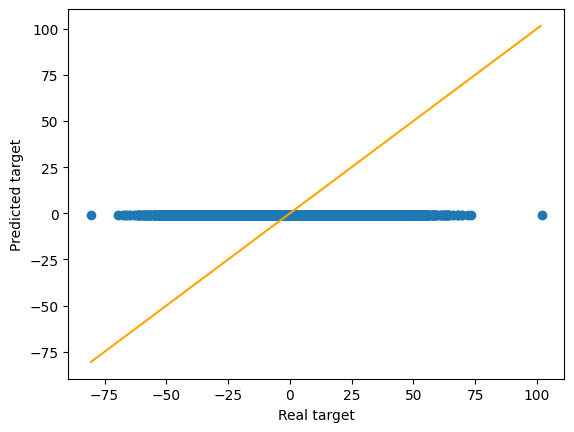

In [113]:
real_vs_pred(season_bl, X_train, y_train)

In [114]:
y_pred_baseline_2 = X_train['PTS_SEASON_BEFORE_AVG_TEAM_HOME'] + X_train['PTS_SEASON_BEFORE_AVG_TEAM_AWAY']

# Evaluate manually
mse = mean_squared_error(y_train, y_pred_baseline_2)
mae = mean_absolute_error(y_train, y_pred_baseline_2)
rmse = root_mean_squared_error(y_train, y_pred_baseline_2)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 44838.36
RMSE: 211.75
MAE: 210.42


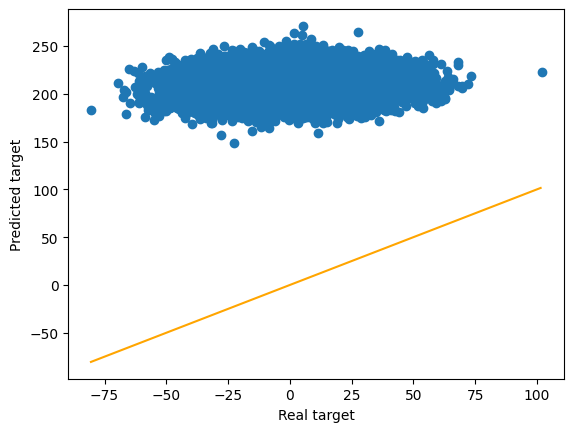

In [115]:
x_line = np.arange(y_train.min(), y_train.max())
plt.scatter(y_train, y_pred_baseline_2)
plt.plot(x_line, x_line, color='orange')
plt.xlabel('Real target')
plt.ylabel('Predicted target')
plt.show()

In [116]:
# Baseline 3: Predict the betting line (TOTAL_OVER_UNDER_LINE)
y_pred_baseline_3 = X_train['TOTAL_OVER_UNDER_LINE']

# Evaluate
mse = mean_squared_error(y_train, y_pred_baseline_3)
mae = mean_absolute_error(y_train, y_pred_baseline_3)
rmse = root_mean_squared_error(y_train, y_pred_baseline_3)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 45986.35
RMSE: 214.44
MAE: 212.67


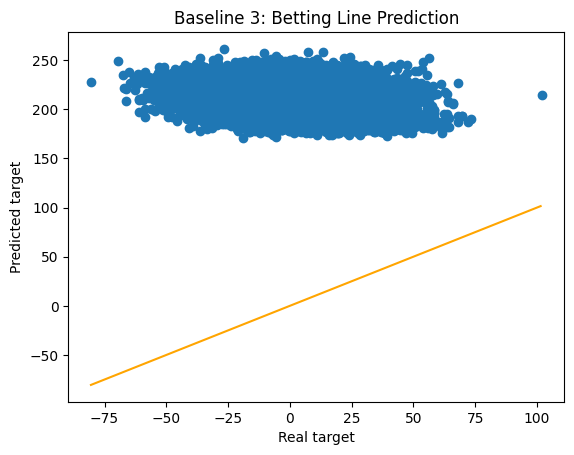

In [117]:
x_line = np.arange(y_train.min(), y_train.max())
plt.scatter(y_train, y_pred_baseline_3)
plt.plot(x_line, x_line, color='orange')
plt.xlabel('Real target')
plt.ylabel('Predicted target')
plt.title('Baseline 3: Betting Line Prediction')
plt.show()

## Linear Regression

In [118]:
from sklearn.linear_model import LinearRegression

In [119]:
lr = LinearRegression()
cv_results = cross_validate(lr, X_train, y_train, cv=kf,
                            scoring=scoring, return_train_score=True)

lr.fit(X_train, y_train)
print_metrics(cv_results)

Train MSE: 275.49697
Validation MSE: 306.76052

Train RMSE: 16.59806
Validation RMSE: 17.51403

Train MAE: 13.18812
Validation MAE: 13.9215

Train OU_Betting_Accuracy: 67.38%
Validation OU_Betting_Accuracy: 64.60%



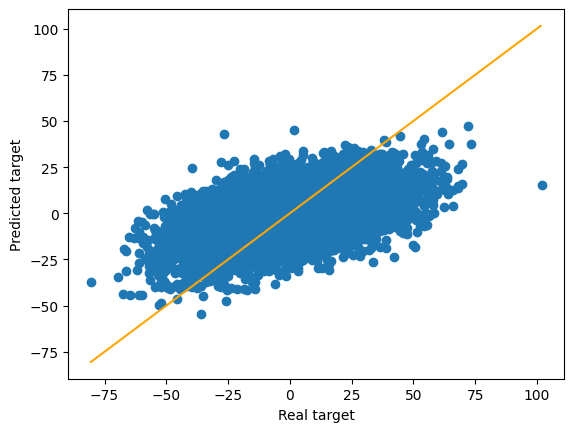

In [120]:
real_vs_pred(lr, X_train, y_train)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
X_train.shape

(14265, 614)

In [ ]:
rf = RandomForestRegressor(100, max_depth=5, max_features=0.6, n_jobs=-1, random_state=16)
cv_results = cross_validate(rf, X_train, y_train, cv=kf,
                            scoring=scoring, return_train_score=True, n_jobs=-1)

rf.fit(X_train, y_train)
print_metrics(cv_results)

Train MSE: 295.86543
Validation MSE: 316.68846

Train RMSE: 17.20066
Validation RMSE: 17.79523

Train MAE: 13.72208
Validation MAE: 14.2071

Train OU_Betting_Accuracy: 66.20%
Validation OU_Betting_Accuracy: 63.59%



In [121]:
import numpy as np
from functools import partial
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate


def sign_flip_weighted_mse_obj_sklearn_ramped(
    y_true,
    y_pred,
    w_same=0.9,
    w_flip_base=1.0,
    w_flip_extra=0.4,
    edge_scale=6.0,
    eps_push=1.0,
):
    """
    Custom objective for XGBRegressor: signature (y_true, y_pred) -> (grad, hess)

    Loss per sample: w * (y_pred - y_true)^2

    Weights:
      - If |y_true| < eps_push: neutral, w = 1.0 (or set to 0.0 if you want to ignore)
      - Same side: w = w_same (typically 0.85–1.0)
      - Sign flip: w = w_flip_base + w_flip_extra * min(1, |y_true| / edge_scale)
        (penalizes flipping more when the true edge is large, capped)
    """
    y_true = np.asarray(y_true, dtype=np.float32)
    y_pred = np.asarray(y_pred, dtype=np.float32)

    err = y_pred - y_true

    neutral = np.abs(y_true) < eps_push
    wrong = (~neutral) & ((y_true * y_pred) < 0)
    same = (~neutral) & (~wrong)

    ramp = np.minimum(1.0, np.abs(y_true) / edge_scale).astype(np.float32)

    w = np.ones_like(y_true, dtype=np.float32)
    w[same] = np.float32(w_same)
    w[wrong] = np.float32(w_flip_base) + np.float32(w_flip_extra) * ramp[wrong]
    w[neutral] = 1.0  # set to 0.0 if you truly want to ignore near-push examples

    grad = 2.0 * w * err
    hess = 2.0 * w
    return grad, hess

custom_obj = partial(
    sign_flip_weighted_mse_obj_sklearn_ramped,
    w_same=0.9,
    w_flip_base=1.0,
    w_flip_extra=0.4,
    edge_scale=6.0,
    eps_push=1.0,
)


xgb_reg = XGBRegressor(
    max_depth=4,              # reduced depth (helps generalization)
    learning_rate=0.025,
    n_estimators=2000,        # use early stopping ideally; if not, higher n_estimators + reg
    subsample=0.8,            # < 1 helps
    colsample_bytree=0.8,
    min_child_weight=10,      # stronger regularization
    reg_lambda=10.0,          # stronger L2
    reg_alpha=0.1,            # optionally 0.1–1.0
    n_jobs=-2,
    tree_method="hist",
    objective=custom_obj,
    eval_metric="rmse",
    random_state=16, 
)
cv_results = cross_validate(
    xgb_reg,
    X_train, y_train,
    cv=kf,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-2,
    error_score="raise",  # helps debug immediately if anything else fails
)

xgb_reg.fit(X_train, y_train)
print_metrics(cv_results)


Train MSE: 89.84864
Validation MSE: 302.16616

Train RMSE: 9.47877
Validation RMSE: 17.38231

Train MAE: 7.38232
Validation MAE: 13.81137

Train OU_Betting_Accuracy: 90.23%
Validation OU_Betting_Accuracy: 64.28%



## Hyperparameter Tuning

In [122]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate

### Randomized Search

### Grid Search

In [123]:
def print_rs_reg_scores(rs_model, best_idx):
    print(rs_model.best_params_)
    print()
    print('Train MAE:', rs_model.cv_results_['mean_train_MAE'][best_idx].round(5))
    print('Validation MAE:', rs_model.cv_results_['mean_test_MAE'][best_idx].round(5))
    print()
    print('Train MSE:', rs_model.cv_results_['mean_train_MSE'][best_idx].round(5))
    print('Validation MSE:', rs_model.cv_results_['mean_test_MSE'][best_idx].round(5))
    print()
    print('Train RMSE:', rs_model.cv_results_['mean_train_RMSE'][best_idx].round(5))
    print('Validation RMSE:', rs_model.cv_results_['mean_test_RMSE'][best_idx].round(5))
    print()
    print('Train OU Betting Accuracy:', f"{rs_model.cv_results_['mean_train_OU_Betting_Accuracy'][best_idx]:.2%}")
    print('Validation OU Betting Accuracy:', f"{rs_model.cv_results_['mean_test_OU_Betting_Accuracy'][best_idx]:.2%}")

In [124]:
import os
n_jobs = max(1, os.cpu_count() - 2)
print(f"Number of jobs: {n_jobs}")

Number of jobs: 10


In [125]:
X_train.shape


(14265, 614)

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define the base model
xgb_reg = XGBRegressor(
    tree_method="hist",
    objective=custom_obj,
    eval_metric="rmse",   # recommended to set explicitly when using a custom objective
    random_state=16,
)

# Define hyperparameter grid
params = [{
    'n_estimators': [200, 500],  # Similar to GBRT
    'learning_rate': [0.02, 0.04, 0.01],  # Fine-tuning LR
    # 'max_depth': [4, 5],  # Keeping it limited for efficiency
    # 'min_child_weight': [3, 4],  # Similar to min_samples_split in GBRT
    # 'subsample': [0.8, 0.5],  # Control for overfitting
    # 'colsample_bytree': [0.8, 1.0],  # Similar to max_features in GBRT
    'gamma': [0],  # Regularization parameter
}]

# GridSearchCV setup
xgb_gs = GridSearchCV(
    xgb_reg,
    param_grid=params,
    scoring=scoring,
    cv=kf,
    verbose=3,
    refit=lambda x: x["mean_test_OU_Betting_Accuracy"].argmax(),  # Select best model based on MAE
    return_train_score=True,
    n_jobs=-1,
)

# Fit model
xgb_gs.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [ ]:
# Print metrics
xgb_gs.best_params_
print_rs_reg_scores(xgb_gs, xgb_gs.best_index_)

{'gamma': 0, 'learning_rate': 0.02, 'n_estimators': 500}

Train MAE: 9.02813
Validation MAE: 13.83944

Train MSE: 134.20231
Validation MSE: 302.78272

Train RMSE: 11.58401
Validation RMSE: 17.39997

Train OU Betting Accuracy: 93.67%
Validation OU Betting Accuracy: 64.68%


In [60]:
{'gamma': 0, 'learning_rate': 0.02, 'n_estimators': 500}


# Pair LR and n_estimators to avoid wasting compute on mismatched combos
param_grid = [
    # Regime A: what your current data seems to like (0.02, ~200) plus nearby
    {
        "learning_rate": [0.02],
        "n_estimators": [500],
        "max_depth": [3, 4, 5,6],
        "min_child_weight": [3, 4,5,6],
        "subsample": [0.5, 0.7],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "gamma": [0, 0.1],
        "reg_lambda": [1, 2],
        "reg_alpha": [0, 0.1],
    }
   
]

xgb_gs = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring=scoring,
    cv=kf,
    verbose=3,
    refit=lambda x: x["mean_test_OU_Betting_Accuracy"].argmax(),  # as you are doing
    return_train_score=True,
    n_jobs=-1,
)

xgb_gs.fit(X_train, y_train)


Fitting 5 folds for each of 768 candidates, totalling 3840 fits
[CV 1/5] END colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; MAE: (train=14.041, test=14.318) MSE: (train=311.414, test=325.460) OU_Betting_Accuracy: (train=0.808, test=0.631) RMSE: (train=17.647, test=18.041) total time= 1.2min
[CV 1/5] END colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.5; MAE: (train=14.084, test=14.355) MSE: (train=313.521, test=326.642) OU_Betting_Accuracy: (train=0.800, test=0.623) RMSE: (train=17.707, test=18.073) total time= 1.2min
[CV 3/5] END colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.5; MAE: (train=14.017, test=14.804) MSE: (train=312.068, test=342.155) OU_Betting_Accuracy: (train=0.799, test=0.651) RMSE: (train=1

GridSearchCV(cv=KFold(n_splits=5, random_state=16, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    in...
             refit=<function <lambda> at 0x771f39564680>,
             return_train_score=True,
             scoring={'MAE': make_scorer(mean_absolute_error, response_method='predict'),
                      'MSE': make_scorer(mean_squared_error, response_method='predict'),
                      'OU_Betting_Accuracy': <__main__.OverUnderScorer object at 0x771f3c3a61e0>,
                      'RMSE': make_scorer(root_mean_squared_error, response_method='predict')},
             verbose=3)

In [61]:
# Print metrics
xgb_gs.best_params_
print_rs_reg_scores(xgb_gs, xgb_gs.best_index_)

{'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.02, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.7}

Train MAE: 9.5717
Validation MAE: 13.88903

Train MSE: 151.73597
Validation MSE: 304.75216

Train RMSE: 12.31805
Validation RMSE: 17.4564

Train OU Betting Accuracy: 92.75%
Validation OU Betting Accuracy: 64.93%


In [63]:
{'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.02, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.7}
xgb_reg = XGBRegressor(
    tree_method="hist",
    objective=custom_obj,
    eval_metric="rmse",   # recommended to set explicitly when using a custom objective
    random_state=16,
)


# Pair LR and n_estimators to avoid wasting compute on mismatched combos
param_grid = [
    # Regime A: what your current data seems to like (0.02, ~200) plus nearby
    {
        "learning_rate": [0.02, 0.025, 0.017,0.1],
        "n_estimators": [500,600,700],
        "max_depth": [6],
        "min_child_weight": [3],
        "subsample": [0.7],
        "colsample_bytree": [0.6],
        "gamma": [0],
        "reg_lambda": [2],
        "reg_alpha": [0],
    }
]

xgb_gs = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring=scoring,
    cv=kf,
    verbose=3,
    refit=lambda x: x["mean_test_OU_Betting_Accuracy"].argmax(),  # as you are doing
    return_train_score=True,
    n_jobs=-2,
)

xgb_gs.fit(X_train, y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 4/5] END colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; MAE: (train=9.599, test=13.883) MSE: (train=152.329, test=304.397) OU_Betting_Accuracy: (train=0.926, test=0.655) RMSE: (train=12.342, test=17.447) total time= 3.3min
[CV 1/5] END colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; MAE: (train=9.586, test=13.618) MSE: (train=152.126, test=295.597) OU_Betting_Accuracy: (train=0.927, test=0.637) RMSE: (train=12.334, test=17.193) total time= 3.6min
[CV 3/5] END colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; MAE: (train=9.604, test=13.866) MSE: (train=152.957, test=302.727) OU_Betting_Accuracy: (train=0.926, test=0.653) RMSE: (train=12.368,

GridSearchCV(cv=KFold(n_splits=5, random_state=16, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    in...
             refit=<function <lambda> at 0x771f39538540>,
             return_train_score=True,
             scoring={'MAE': make_scorer(mean_absolute_error, response_method='predict'),
                      'MSE': make_scorer(mean_squared_error, response_method='predict'),
                      'OU_Betting_Accuracy': <__main__.OverUnderScorer object at 0x771f3c3a61e0>,
                      'RMSE': make_scorer(root_mean_squared_error, response_method='predict')},
             verbose=3)

In [64]:
# Print metrics
xgb_gs.best_params_
print_rs_reg_scores(xgb_gs, xgb_gs.best_index_)

{'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.02, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 600, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.7}

Train MAE: 8.87818
Validation MAE: 13.84349

Train MSE: 131.42779
Validation MSE: 303.10714

Train RMSE: 11.46414
Validation RMSE: 17.4093

Train OU Betting Accuracy: 93.66%
Validation OU Betting Accuracy: 65.05%


In [65]:
{'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.02, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 600, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.7}


param_grid = [
    {
        "learning_rate": [0.02],
        "n_estimators": [650,600,550],
        "max_depth": [6],
        "min_child_weight": [3],
        "subsample": [0.7, 0.6],
        "colsample_bytree": [0.6],
        "gamma": [0],
        "reg_lambda": [2],
        "reg_alpha": [0],
    }
]

xgb_gs = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring=scoring,
    cv=kf,
    verbose=1,
    refit=lambda x: x["mean_test_OU_Betting_Accuracy"].argmax(),  # as you are doing
    return_train_score=True,
    n_jobs=-2,
)

xgb_gs.fit(X_train, y_train)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=16, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    in...
             refit=<function <lambda> at 0x771f8d280360>,
             return_train_score=True,
             scoring={'MAE': make_scorer(mean_absolute_error, response_method='predict'),
                      'MSE': make_scorer(mean_squared_error, response_method='predict'),
                      'OU_Betting_Accuracy': <__main__.OverUnderScorer object at 0x771f3c3a61e0>,
                      'RMSE': make_scorer(root_mean_squared_error, response_method='predict')},
             verbose=1)

In [67]:
# Print metrics
xgb_gs.best_params_
print_rs_reg_scores(xgb_gs, xgb_gs.best_index_)

{'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.02, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 600, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.7}

Train MAE: 8.87818
Validation MAE: 13.84349

Train MSE: 131.42779
Validation MSE: 303.10714

Train RMSE: 11.46414
Validation RMSE: 17.4093

Train OU Betting Accuracy: 93.66%
Validation OU Betting Accuracy: 65.05%


In [68]:
import pickle

# Get the best model
best_model = xgb_gs.best_estimator_
#get_date
import datetime
now = datetime.datetime.now()
date_today = now.strftime("%Y-%m-%d")

name = f"best_xgboost_{prefix_name}{date_today}.pkl"
name_config = f"best_xgboost_{prefix_name}config_{date_today}.pkl"
# Save the best model
with open(save_models_path+name, "wb") as f:
    pickle.dump(best_model, f)

# Save the best model configuration
with open(save_models_path+name_config, "wb") as f:
    pickle.dump(xgb_gs.best_params_, f)

print("Best model saved as", name)

Best model saved as best_xgboost_regressor_dif_2026-01-22.pkl


In [ ]:
# name = "/home/adrian_alvarez/Projects/NBA_over_under_predictor/models/total_points/best_xgboost_regressor_total_2026-01-20.pkl"
import pickle
#load model
with open(save_models_path+name, "rb") as f:
    best_model = pickle.load(f)

In [70]:
feature_importances = best_model.feature_importances_
important_features = np.argsort(feature_importances)[::-1]  
feature_importances = pd.DataFrame({
    'Feature': X_train.columns[important_features],
    'Importance': feature_importances[important_features]
}).sort_values(by="Importance", ascending=False)
feature_importances

,Feature,Importance
0,TOTAL_POINTS_LAST_10_WMA_BEFORE_TEAM_AWAY,0.007010
1,EXPECTED_POSS_FROM_PACE,0.005486
2,PTS_LAST_10_WMA_BEFORE_TEAM_AWAY,0.005435
3,POSS_LAST_ALL_10_MATCHES_BEFORE_TEAM_HOME,0.004849
4,TOP5_INJURED_PLAYER_PTS_BEFORE_TEAM_HOME,0.004525
...,...,...
609,IS_PLAYOFF_GAME,0.000005
610,TOP6_INJURED_PLAYER_PTS_BEFORE_TEAM_HOME,0.000000
611,TOP6_INJURED_PLAYER_PTS_BEFORE_TEAM_AWAY,0.000000
612,TOP6_INJURED_PLAYER_DEF_RATING_BEFORE_TEAM_HOME,0.000000


In [71]:
n_columns = X_train.shape[1]
only_important_features =  X_train.columns[important_features][:int(n_columns * 0.667)]

In [ ]:
#repeat the analysis with only important features
xgb_reg_only_import = XGBRegressor(**best_model.get_params())

cv_results_important = cross_validate(
    xgb_reg_only_import, 
    X_train[only_important_features], y_train, 
    cv=kf, 
    scoring=scoring,      # Use your custom scoring or e.g. 'neg_mean_absolute_error'
    return_train_score=True,
    n_jobs=-1
)
# Train final model on full train set
xgb_reg_only_import.fit(X_train[only_important_features], y_train)

# Print metrics
print_metrics(cv_results_important)

TypeError: xgboost.sklearn.XGBRegressor() got multiple values for keyword argument 'objective'

In [74]:
best_model.get_params()


{'objective': functools.partial(<function sign_flip_weighted_mse_obj_sklearn at 0x771f8f981260>, w_same=0.5, w_flip=3.0, eps_push=0.5),
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.6,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'rmse',
 'feature_types': None,
 'gamma': 0,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.02,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 6,
 'max_leaves': None,
 'min_child_weight': 3,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 600,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 16,
 'reg_alpha': 0,
 'reg_lambda': 2,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.7,
 'tree_method': 'hist',
 'validate_parameters': N

In [ ]:

{'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.025, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 600, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.6}
# Define the base model
xgb_reg = XGBRegressor(random_state=16, n_jobs=10)

# Define hyperparameter grid
params = [{
    'n_estimators': [600],  # Similar to GBRT
    'learning_rate': [0.02, 0.025],  # Fine-tuning LR
    'max_depth': [3,4,5,6],  # Keeping it limited for efficiency
    'min_child_weight': [3,4,5],  # Similar to min_samples_split in GBRT
    'subsample': [0.6, 0.7, 0.5],  # Control for overfitting
    'colsample_bytree': [0.8, 0.6],  # Similar to max_features in GBRT
    'gamma': [0],
    'reg_alpha': [0.1],
    'reg_lambda': [1],  # Regularization parameter
}]

# GridSearchCV setup
xgb_gs_import = GridSearchCV(
    xgb_reg,
    param_grid=params,
    scoring=scoring,
    cv=kf,
    verbose=3,
    refit=lambda x: x["mean_test_OU_Betting_Accuracy"].argmax(),  # as you are doing
    return_train_score=True,
    n_jobs= 10
)

# Fit model
xgb_gs_import.fit(X_train[only_important_features], y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=600, reg_alpha=0.1, reg_lambda=1, subsample=0.7; MAE: (train=12.688, test=13.745) MSE: (train=253.756, test=296.186) OU_Betting_Accuracy: (train=0.697, test=0.656) RMSE: (train=15.930, test=17.210) total time=  29.3s
[CV 4/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=600, reg_alpha=0.1, reg_lambda=1, subsample=0.6; MAE: (train=12.650, test=13.896) MSE: (train=252.056, test=304.564) OU_Betting_Accuracy: (train=0.698, test=0.644) RMSE: (train=15.876, test=17.452) total time=  30.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=600, reg_alpha=0.1, reg_lambda=1, subsample=0.6; MAE: (train=12.705, test=13.710) MSE: (train=254.204, test=295.192) OU_Betting_Accuracy: (train=0.698, test=0.657) RMSE: (tr

GridSearchCV(cv=KFold(n_splits=5, random_state=16, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    inte...
             refit=<function <lambda> at 0x74733efec9a0>,
             return_train_score=True,
             scoring={'MAE': make_scorer(mean_absolute_error, response_method='predict'),
                      'MSE': make_scorer(mean_squared_error, response_method='predict'),
                      'OU_Betting_Accuracy': <__main__.OverUnderScorer object at 0x74733f14ab70>,
                      'RMSE': make_scorer(root_mean_squared_error, response_method='predict')},
             verbose=3)

In [ ]:
# Print metrics
xgb_gs_import.best_params_
print_rs_reg_scores(xgb_gs_import, xgb_gs_import.best_index_)

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.02, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 600, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.6}

Train MAE: 10.62779
Validation MAE: 13.65544

Train MSE: 177.87293
Validation MSE: 294.7357

Train RMSE: 13.33688
Validation RMSE: 17.16689

Train OU Betting Accuracy: 78.42%
Validation OU Betting Accuracy: 65.38%


In [ ]:

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.02, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 600, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.6}

# Define the base model
xgb_reg = XGBRegressor(random_state=16, n_jobs=-2)

# Define hyperparameter grid
params = [{
    'n_estimators': [600, 750, 1000],  # Similar to GBRT
    'learning_rate': [0.02, 0.017, 0.023],  
    'max_depth': [5],  # Keeping it limited for efficiency
    'min_child_weight': [ 3],  # Similar to min_samples_split in GBRT
    'subsample': [0.6],  # Control for overfitting
    'colsample_bytree': [0.8],  # Similar to max_features in GBRT
    'gamma': [0],
    'reg_alpha': [0.1],
    'reg_lambda': [1], 
    # 'colsample_bylevel': [0.7, 0.8,  1.0],
    # 'colsample_bynode': [0.8, 0.9, 1.0],# Regularization parameter
}]

# GridSearchCV setup
xgb_gs_import = GridSearchCV(
    xgb_reg,
    param_grid=params,
    scoring=scoring,
    cv=kf,
    verbose=3,
    refit=lambda x: x["mean_test_OU_Betting_Accuracy"].argmax(),  # as you are doing
    return_train_score=True,
    n_jobs=-2
)

# Fit model
xgb_gs_import.fit(X_train[only_important_features], y_train)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 2/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=600, reg_alpha=0.1, reg_lambda=1, subsample=0.6; MAE: (train=10.642, test=13.539) MSE: (train=178.641, test=285.485) OU_Betting_Accuracy: (train=0.784, test=0.656) RMSE: (train=13.366, test=16.896) total time= 1.1min
[CV 1/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=600, reg_alpha=0.1, reg_lambda=1, subsample=0.6; MAE: (train=10.625, test=13.677) MSE: (train=177.870, test=295.099) OU_Betting_Accuracy: (train=0.783, test=0.655) RMSE: (train=13.337, test=17.178) total time= 1.1min
[CV 4/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=600, reg_alpha=0.1, reg_lambda=1, subsample=0.6; MAE: (train=10.591, test=13.867) MSE: (train=176.715, test=304.754) OU_Betting_Accuracy: (train=0.785, test=0.659) RMSE: (train

GridSearchCV(cv=KFold(n_splits=5, random_state=16, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    inte...
             refit=<function <lambda> at 0x74733ef805e0>,
             return_train_score=True,
             scoring={'MAE': make_scorer(mean_absolute_error, response_method='predict'),
                      'MSE': make_scorer(mean_squared_error, response_method='predict'),
                      'OU_Betting_Accuracy': <__main__.OverUnderScorer object at 0x74733f14ab70>,
                      'RMSE': make_scorer(root_mean_squared_error, response_method='predict')},
             verbose=3)

In [ ]:
xgb_gs_import.best_params_
print_rs_reg_scores(xgb_gs_import, xgb_gs_import.best_index_)

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.02, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 600, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.6}

Train MAE: 10.62779
Validation MAE: 13.65544

Train MSE: 177.87293
Validation MSE: 294.7357

Train RMSE: 13.33688
Validation RMSE: 17.16689

Train OU Betting Accuracy: 78.42%
Validation OU Betting Accuracy: 65.38%


In [ ]:

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.02, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 600, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.6}

# Define the base model
xgb_reg = XGBRegressor(random_state=16, n_jobs=-2)

# Define hyperparameter grid
params = [{
    'n_estimators': [600, 650],  # Similar to GBRT
    'learning_rate': [0.02],  
    'max_depth': [5],  # Keeping it limited for efficiency
    'min_child_weight': [ 3],  # Similar to min_samples_split in GBRT
    'subsample': [0.6],  # Control for overfitting
    'colsample_bytree': [0.8],  # Similar to max_features in GBRT
    'gamma': [0],
    'reg_alpha': [0.1],
    'reg_lambda': [1], 
    'colsample_bylevel': [0.7, 0.8,  1.0],
    'colsample_bynode': [0.8, 0.9, 1.0],# Regularization parameter
}]

# GridSearchCV setup
xgb_gs_import = GridSearchCV(
    xgb_reg,
    param_grid=params,
    scoring=scoring,
    cv=kf,
    verbose=3,
    refit=lambda x: x["mean_test_OU_Betting_Accuracy"].argmax(),  # as you are doing
    return_train_score=True,
    n_jobs=-2
)

# Fit model
xgb_gs_import.fit(X_train[only_important_features], y_train)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 2/5] END colsample_bylevel=0.7, colsample_bynode=0.8, colsample_bytree=0.8, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=600, reg_alpha=0.1, reg_lambda=1, subsample=0.6; MAE: (train=10.792, test=13.558) MSE: (train=184.319, test=286.676) OU_Betting_Accuracy: (train=0.781, test=0.660) RMSE: (train=13.576, test=16.932) total time= 1.2min
[CV 5/5] END colsample_bylevel=0.7, colsample_bynode=0.8, colsample_bytree=0.8, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=650, reg_alpha=0.1, reg_lambda=1, subsample=0.6; MAE: (train=10.559, test=13.595) MSE: (train=175.542, test=293.758) OU_Betting_Accuracy: (train=0.788, test=0.646) RMSE: (train=13.249, test=17.139) total time= 1.2min
[CV 3/5] END colsample_bylevel=0.7, colsample_bynode=0.8, colsample_bytree=0.8, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=600, reg_alpha=0.1, reg_lambda=1, subsam

GridSearchCV(cv=KFold(n_splits=5, random_state=16, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    inte...
             refit=<function <lambda> at 0x74733ef83920>,
             return_train_score=True,
             scoring={'MAE': make_scorer(mean_absolute_error, response_method='predict'),
                      'MSE': make_scorer(mean_squared_error, response_method='predict'),
                      'OU_Betting_Accuracy': <__main__.OverUnderScorer object at 0x74733f14ab70>,
                      'RMSE': make_scorer(root_mean_squared_error, response_method='predict')},
             verbose=3)

In [ ]:
xgb_gs_import.best_params_
print_rs_reg_scores(xgb_gs_import, xgb_gs_import.best_index_)

{'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.02, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 600, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.6}

Train MAE: 10.62779
Validation MAE: 13.65544

Train MSE: 177.87293
Validation MSE: 294.7357

Train RMSE: 13.33688
Validation RMSE: 17.16689

Train OU Betting Accuracy: 78.42%
Validation OU Betting Accuracy: 65.38%


In [ ]:
import pickle

# Get the best model
best_model = xgb_gs_import.best_estimator_
#get_date
import datetime
now = datetime.datetime.now()
date_today = now.strftime("%Y-%m-%d")
name = f"best_xgboost_{prefix_name}important_{date_today}.pkl"
name_config = f"best_xgboost_{prefix_name}important_config_{date_today}.pkl"
# Save the best model
with open(save_models_path+ name, "wb") as f:
    pickle.dump(best_model, f)

print("Best model saved as", name)

Best model saved as best_xgboost_regressor_total_bet_important_2026-01-21.pkl


# Train whole data

In [ ]:
name_total = "/home/adrian_alvarez/Projects/NBA_over_under_predictor/models/total_points_bet_accuracy/best_xgboost_regressor_total_bet_2026-01-21.pkl"

In [ ]:
import pickle

with open(name_total, "rb") as f:
    best_model_total_features = pickle.load(f)

In [ ]:
from xgboost import XGBRegressor

production_model = XGBRegressor(**best_model_total_features.get_params())
production_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.025, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=-2,
             num_parallel_tree=None, random_state=16, ...)

In [ ]:
# insert in the model before the .pickle full_dataset 
production_model_filename = f"{name_total.replace('.pkl', '_production.pkl')}"
with open(production_model_filename, "wb") as f:
    pickle.dump(production_model, f)

print("Production-ready model saved as", production_model_filename)

Production-ready model saved as /home/adrian_alvarez/Projects/NBA_over_under_predictor/models/total_points_bet_accuracy/best_xgboost_regressor_total_bet_2026-01-21_production.pkl


In [ ]:
name_important = "/home/adrian_alvarez/Projects/NBA_over_under_predictor/models/total_points_bet_accuracy/best_xgboost_regressor_total_bet_important_2026-01-21.pkl"

In [ ]:
import pickle

with open(name_important, "rb") as f:
    best_model_important_features = pickle.load(f)

In [ ]:
from xgboost import XGBRegressor
trained_features = best_model_important_features.feature_names_in_

production_model_important = XGBRegressor(
    **best_model_important_features.get_params()
)

production_model_important.fit(
    X[trained_features],
    y
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=0.8,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=-2, num_parallel_tree=None, random_state=16, ...)

In [ ]:
# insert in the model before the .pickle full_dataset 
production_model_important_filename = f"{name_important.replace('.pkl', '_production.pkl')}"
with open(production_model_important_filename, "wb") as f:
    pickle.dump(production_model_important, f)

print("Production-ready model (important features) saved as", production_model_important_filename)

Production-ready model (important features) saved as /home/adrian_alvarez/Projects/NBA_over_under_predictor/models/total_points_bet_accuracy/best_xgboost_regressor_total_bet_important_2026-01-21_production.pkl


In [ ]:
df_until_25 = df_to_train[df_to_train['SEASON_YEAR'] < 2025]


X2 = df_until_25.drop(cols_to_drop + ['TOTAL_POINTS'], axis=1, errors='ignore')
y2 = df_until_25['TOTAL_POINTS']

KeyError: 'GAME_DATE'

In [ ]:
from xgboost import XGBRegressor

production_model = XGBRegressor(**best_model_total_features.get_params())
production_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.025, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=-2,
             num_parallel_tree=None, random_state=16, ...)

In [ ]:
# insert in the model before the .pickle full_dataset 
production_model_filename = f"{name_total.replace('.pkl', '_production_till_2025.pkl')}"
with open(production_model_filename, "wb") as f:
    pickle.dump(production_model, f)

print("Production-ready model saved as", production_model_filename)

Production-ready model saved as /home/adrian_alvarez/Projects/NBA_over_under_predictor/models/total_points_bet_accuracy/best_xgboost_regressor_total_bet_2026-01-21_production_till_2025.pkl
